<a href="https://colab.research.google.com/github/UlkuTuncerKucuktas/KneeOsteoarthritisCNN/blob/main/KneeOsteoarthritisCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/MyDrive/veri.zip"  -d  "/content/Image_Folder3"

In [4]:
from distutils.dir_util import copy_tree
import os 
def createTrainFolder(dirs):
  for dir in dirs:
    try:
      os.makedirs("/content/train/0/")
      os.makedirs("/content/train/1/")
      os.makedirs("/content/train/2/")
      os.makedirs("/content/train/3/")
      os.makedirs("/content/train/4/")
    except:
      pass

    copy_tree(dir+"/0/","/content/train/0/")
    copy_tree(dir+"/1/","/content/train/1/")
    copy_tree(dir+"/2/","/content/train/2/")
    copy_tree(dir+"/3/","/content/train/3/")
    copy_tree(dir+"/4/","/content/train/4/")

def createValFolder(dirs):
  for dir in dirs:
    try:
      os.makedirs("/content/val/0/")
      os.makedirs("/content/val/1/")
      os.makedirs("/content/val/2/")
      os.makedirs("/content/val/3/")
      os.makedirs("/content/val/4/")
    except:
      pass

    copy_tree(dir+"/0/","/content/val/0/")
    copy_tree(dir+"/1/","/content/val/1/")
    copy_tree(dir+"/2/","/content/val/2/")
    copy_tree(dir+"/3/","/content/val/3/")
    copy_tree(dir+"/4/","/content/val/4/")


dirs = ["/content/Image_Folder3/KneeXrayData/ClsKLData/kneeKL224/train","/content/Image_Folder3/KneeXrayData/ClsKLData/kneeKL224/test"]
createTrainFolder(dirs)
createValFolder(["/content/Image_Folder3/KneeXrayData/ClsKLData/kneeKL224/val"])


In [20]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [21]:
import numpy as np
import cv2
def toGrayScale(img):
  img = np.array(img) 
  if(len(img.shape) == 3):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  
  return img


In [22]:
from torchvision import datasets, transforms as T

transformfunc = T.Compose([toGrayScale, T.ToTensor(),T.Resize(256), T.CenterCrop(224)])

In [23]:
import torch
import torchvision.datasets as datasets

train_set = datasets.ImageFolder("/content/train",transform=transformfunc)
val_set = datasets.ImageFolder("/content/val",transform=transformfunc)

In [24]:
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=train_set,batch_size=32,shuffle=True)
valloader = DataLoader(dataset=val_set,batch_size=1,shuffle=False)

In [25]:
import sklearn
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced',[0,1,2,3,4],train_set.targets )
class_weights

array([0.50830769, 1.10789866, 0.75741212, 1.51714286, 6.6375    ])

In [26]:
train_set

Dataset ImageFolder
    Number of datapoints: 7434
    Root location: /content/train
    StandardTransform
Transform: Compose(
               <function toGrayScale at 0x7fee2d9170e0>
               ToTensor()
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
           )

In [29]:
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d,Dropout,Sigmoid,BatchNorm2d

class Net(nn.Module):
  def __init__(self):
     super(Net, self).__init__()
     self.cnn_layers = Sequential(
     Conv2d(1,32, kernel_size=2, stride=1, padding=1),
     BatchNorm2d(32),
     ReLU(inplace=True),
     MaxPool2d(kernel_size=2, stride=2),
     Conv2d(32,64, kernel_size=2, stride=1, padding=1),
     BatchNorm2d(64),
     ReLU(inplace=True),
     MaxPool2d(kernel_size=2, stride=2),
     Conv2d(64,128, kernel_size=2, stride=1, padding=1),
     BatchNorm2d(128),
     ReLU(inplace=True),
     MaxPool2d(kernel_size=2, stride=2),
     Conv2d(128,256, kernel_size=2, stride=1, padding=1),
     BatchNorm2d(256),
     ReLU(inplace=True),
     MaxPool2d(kernel_size=2, stride=2)
     )
     self.linear_layers = Sequential( 
        Linear(50176,128),
        Linear(128,5)
        )
     #Defining the forward pass
  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)

    return x

model = Net()
model = model.to(device)

In [30]:
from sklearn.metrics import f1_score

criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))

optimizer = torch.optim.Adam(model.parameters())


def train(model,criterion,train_loader,optimizer,epochs = 10):
  train_loss = []
  for epoch in range(epochs):
    running_loss = 0.0
    for i,(x,y) in enumerate(train_loader):
      x,y = x.to(device),y.to(device) # Modele girecek tensorları cudaya gönder
      optimizer.zero_grad()
      z = model(x)
      loss = criterion(z,y)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if i % 52 == 51 :
        preds = []
        actuals = []
        for x,y in valloader:
          x,y = x.to(device),y.to(device).to(torch.float32)
          z = model(x)
          label = torch.max(z,-1).indices.item()
          preds.append(label)
          actuals.append(y.item())
        score = f1_score(actuals,preds, average='macro')
        print("F1 score :",score)
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 20))



train(model,criterion,trainloader,optimizer,15)

F1 score : 0.06266996093083049
[1,    52] loss: 35.858
F1 score : 0.08129637820040296
[1,   104] loss: 44.711
F1 score : 0.1760677526859772
[1,   156] loss: 50.608
F1 score : 0.19727985851019558
[1,   208] loss: 55.577
F1 score : 0.2593189189462481
[2,    52] loss: 4.874
F1 score : 0.26307358638520795
[2,   104] loss: 9.749
F1 score : 0.26673247346005075
[2,   156] loss: 14.817
F1 score : 0.18877138436679886
[2,   208] loss: 18.989
F1 score : 0.2400483379963098
[3,    52] loss: 3.904
F1 score : 0.2383755487743223
[3,   104] loss: 7.765
F1 score : 0.25024934128334525
[3,   156] loss: 11.367
F1 score : 0.3449065769977147
[3,   208] loss: 14.798
F1 score : 0.3619826462883471
[4,    52] loss: 3.316
F1 score : 0.36536693464674475
[4,   104] loss: 6.659
F1 score : 0.4427858041123109
[4,   156] loss: 9.879
F1 score : 0.3633583639595047
[4,   208] loss: 13.031
F1 score : 0.47497368831633135
[5,    52] loss: 3.048
F1 score : 0.3887588645738871
[5,   104] loss: 6.458
F1 score : 0.451999098596263

In [31]:
from sklearn.metrics import confusion_matrix

preds = []
actuals = []
for x,y in valloader:
  x,y = x.to(device),y.to(device).to(torch.float32)
  z = model(x)
  label = torch.max(z,-1).indices.item()
  preds.append(label)
  actuals.append(y.item())
matrix = confusion_matrix(actuals,preds)
matrix

array([[199,  32,  81,  14,   2],
       [ 70,  16,  50,  17,   0],
       [ 37,   9, 122,  43,   1],
       [  2,   1,  15,  78,  10],
       [  0,   0,   1,   5,  21]])

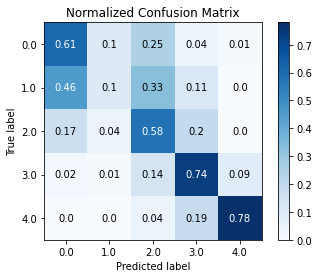

In [37]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(actuals, preds,normalize=True)

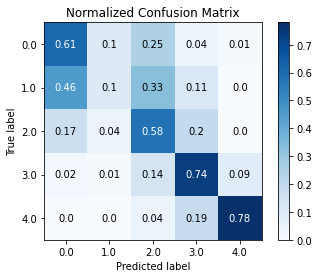

In [36]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(actuals, preds,normalize=True)

In [38]:
from sklearn.metrics import classification_report

print(classification_report(actuals,preds, target_names=["Category 1","Category 2","Category 3","Category 4","Category 5"]))

              precision    recall  f1-score   support

  Category 1       0.65      0.61      0.63       328
  Category 2       0.28      0.10      0.15       153
  Category 3       0.45      0.58      0.51       212
  Category 4       0.50      0.74      0.59       106
  Category 5       0.62      0.78      0.69        27

    accuracy                           0.53       826
   macro avg       0.50      0.56      0.51       826
weighted avg       0.51      0.53      0.51       826

